Fit some of the rotation curves from SV3 using the rotation curve parameterization

\begin{equation}
  V(r) = \frac{V_\text{max}r}{(R_\text{turn}^\alpha + r^\alpha)^{1/\alpha}}
\end{equation}

In [24]:
from astropy.table import QTable
from astropy.io import fits

from scipy.optimize import minimize

import numpy as np

import matplotlib.pyplot as plt

In [9]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/masking/SGA-ellipse-v3.0.kd.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

In [10]:
PV_SGA_ztable = QTable.read('../PV_SGA_vel_05062021.fits', format='fits')

PV_SGA_ztable[:10]

PROGRAM,TARGETID,DATE,PETAL,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,TILEID,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,IDX_SGA,SKY_DIST_SGA,SKY_TARGET_DIST_SGA,SKY_FIBER_DIST_SGA,V_ROT,V_ROT_ERR,RADIUS
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,deg,km / s,km / s,
bytes14,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
PV_BRIGHT_HIGH,1070078338531340,20210420,1,8787.038535818458,32.8816141813718 .. -3.7176505831015008,0.031198201144749936,4.666633789860146e-06,0,7880,GALAXY,,10,679.332183137536,0,1,1,330,1330,980,0,215.4080415770057,-1.4543685705057612,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,243.48737,-192.40593,1700,0.7977878019837114,63,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,1700,5,4611686018427387904,0,0,8796093022208,0,0,0,2,243.457,-192.382,-0.008,0.003,215.4080106650713,-1.454379601523145,666.0406,0.7924211544834598,20210420,85631,59325.31947479,230,999999,999999,999999,999999,999999,999999,999999,999999,53010,0.0014780697426945001,0.0014780697426944945,0.0014464693851510273,-61.49987954764533,1.6049864488223995,0.32958889631124655
PV_DARK_HIGH,1083272478064650,20210503,1,9169.24156068964,-32.659360007937096 .. 6.680353076858249,0.0317084061869926,1.8343003150568484e-05,0,7783,GALAXY,,10,46.98668561177328,0,1,1,371,1371,966,0,215.40366558016564,-1.4547203452425466,0.0,0.0,2015.5,5400.0,4611686018427387904,1,TGT,252.99539,-208.04816,1700,0.7977878019837114,63,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,1700,5,4611686018427387904,0,0,70368744177664,0,0,0,2,252.94,-208.024,0.007,0.009,215.40369359902135,-1.4547563650705024,1524.4433,0.7927957606754578,20210503,87112,59338.30187835,225,999999,999999,999999,999999,999999,999999,999999,999999,53010,0.002910691795037707,0.002910691795037706,0.0028860473542298127,91.45574415027775,5.555065693739474,0.6576075317925104
PV_DARK_MEDIUM,39627752101383445,20210417,1,8532.71464689076,1700.0066621703295 .. 47.148745916083335,0.03140303681763694,2.8409868262934057e-06,0,7853,GALAXY,,10,3320.6057104319334,0,1,1,269,1269,820,0,215.4065974981993,-1.4544846571064665,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,191.71579,-209.96027,102100,0.5906080638046524,575,9010,322589,3349,SER,48.835087,68.

# Rotation curve functions

From `dark_matter_mass_v1.py`

In [25]:
def rot_fit_BB( depro_radius, params):
    """
    Function to fit the rotation curve data to.


    PARAMETERS
    ==========
    
    depro_radius : float or ndarray of shape (n,)
        Deprojected radius as taken from the [PLATE]-[FIBERID] rotation curve 
        data file (in units of kpc); the "x" data of the rotation curve equation

    v_max : float
        The maximum velocity (or in the case of fitting the negative, the
        absolute value of the minimum velocity) parameter of the rotation curve 
        equation (given in km/s)

    r_turn : float
        The radius at which the rotation curve trasitions from increasing to 
        flat-body for the rotation curve equation (given in kpc)

    alpha : float
        The exponential parameter for the rotation curve equation


    RETURNS
    =======
        
    The rotation curve equation with the given '@param' parameters and
    'depro_radius' data
    """

    v_max, r_turn, alpha = params

    v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))

    v = v*np.sign(depro_radius)

    return v


def logL_BB(params, r, v, v_err):
    '''
    Log likelihood of the data and the fit values for the BB fit function.


    PARAMETERS
    ==========

    params : list or ndarray
        List of 3 fit parameters

    r : ndarray
        Radius values for the data points

    v : ndarray
        Velocity values for the data points

    v_err : ndarray
        Velocity error values for the data points


    RETURNS
    =======

    logL : float
        Log likelihood of set velocity given model parameters
    '''

    lambda1 = rot_fit_BB(r, params)
    lambda1[lambda1 <= 0] = np.finfo( dtype=np.float64).tiny

    return np.sum( ((v - lambda1)/v_err)**2 + np.log(2*np.pi*np.array(v_err)**2))


def nlogL_BB(params, radius, velocity, velocity_err):
    '''
    Negative log likelihood, for minimizing.
    '''
    return -logL_BB(params, radius, velocity, velocity_err)

# Fit rotation curve

In [53]:
galaxy = 'PGC2403372'

SGA_index = np.argwhere(SGA['GALAXY'] == galaxy)[0]

gal_index = np.argwhere(PV_SGA_ztable['IDX_SGA'] == SGA_index)

In [54]:
gal_table = PV_SGA_ztable[gal_index]

gal_table[['SPECTYPE', 'RADIUS', 'V_ROT', 'V_ROT_ERR']]

SPECTYPE [1],RADIUS [1],V_ROT [1],V_ROT_ERR [1]
,,km / s,km / s
bytes6,float64,float64,float64
GALAXY,0.340172692366619,261.32376468344995,14.919098859395056
GALAXY,0.6717900755276907,-224.03991889930748,8.19043576030275
GALAXY,0.004184769273022973,-0.8651083295334672,7.323649964359892
GALAXY,0.0027957086545224883,-7.107449202385029,10.21322516164387


In [55]:
# R_turn
r_turn_guess = 0.5 # R(26)
r_turn_low = 0.001 # R(26)
r_turn_high = 2.   # R(26)
r_turn_bounds = (r_turn_low, r_turn_high)

# Vmax
v_max_guess = np.max(np.abs(gal_table['V_ROT'].data))
v_max_low = 1.0    # km/s
v_max_high = 1000. # km/s
v_max_bounds = (v_max_low, v_max_high)

# alpha
alpha_guess = 2.
alpha_low = np.nextafter(0,1)
alpha_high = 10.
alpha_bounds = (alpha_low, alpha_high)

rot_param_bounds = [v_max_bounds, r_turn_bounds, alpha_bounds]


results = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in rot_param_bounds]
    result = minimize(nlogL_BB, 
                      p0, 
                      method='L-BFGS-B', 
                      args=(gal_table['RADIUS'], np.abs(gal_table['V_ROT'].data), gal_table['V_ROT_ERR'].data), 
                      bounds=rot_param_bounds)
    if result.success:
        if results is None:
            results = result
        else:
            if result.fun < results.fun:
                results = result

rot_perr = np.sqrt(np.diag(results.hess_inv.todense()))

results

<ipython-input-25-b76920e7bcaf>:35: RuntimeWarning: overflow encountered in double_scalars
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


      fun: <Quantity -39515.62318421>
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.60650516e+01,  6.75283809e+02, -7.71251443e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 32
      nit: 2
     njev: 8
   status: 0
  success: True
        x: array([1.e+03, 1.e-03, 1.e+01])

<ipython-input-56-224f3210dc3d>:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(gal_table['RADIUS'], np.abs(gal_table['V_ROT']), yerr=gal_table['V_ROT_ERR'], fmt='o')


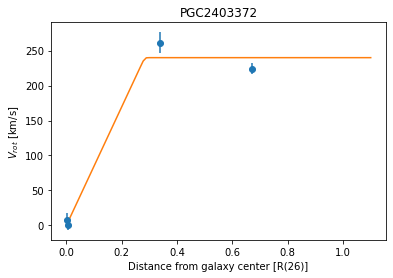

In [56]:
plt.figure()

plt.errorbar(gal_table['RADIUS'], np.abs(gal_table['V_ROT']), yerr=gal_table['V_ROT_ERR'], fmt='o')

R = np.linspace(0,1.1,100)
plt.plot(R,rot_fit_BB(R, [239.9, 0.2831, 109.5])) # Fit values from MATLAB

plt.xlabel('Distance from galaxy center [R(26)]')
plt.ylabel('$V_{rot}$ [km/s]')

plt.title(galaxy)

plt.savefig('../images/PV_fits/' + galaxy + '_fit.png', format='png', dpi=300);